_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c4_interpolated_2450_50.csv")
training_set = data.iloc[:, 1]
training_set

0       88.600000
1       88.409524
2       88.219048
3       88.028571
4       87.838095
          ...    
2495    55.049190
2496    55.036893
2497    55.024595
2498    55.012298
2499    55.000000
Name: C4, Length: 2500, dtype: float64

In [6]:
test = training_set.tail(50)
test
training_set = training_set.head(2450)
training_set

0       88.600000
1       88.409524
2       88.219048
3       88.028571
4       87.838095
          ...    
2445     0.000000
2446     0.530742
2447     0.000000
2448     0.765768
2449     0.000000
Name: C4, Length: 2450, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,88.600000,0.000298
1,88.409524,0.000298
2,88.219048,0.000297
3,88.028571,0.000297
4,87.838095,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

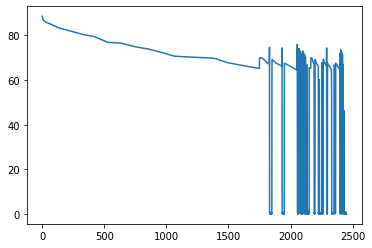

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

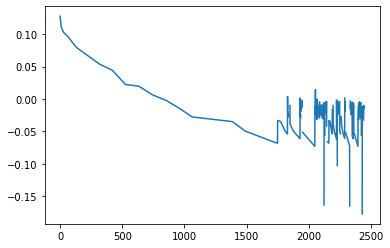

In [11]:
import numpy as np
c0 = 86.6856  # Value for C0
K0 = -0.0008  # Value for K0
K1 = -0.0002  # Value for K1
a = 0.0000    # Value for a
b = 0.0128    # Value for b
c = -2.3003    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 175, n_out = 50)


cols_to_drop = []
for i in range(2, 176):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-175)  var1(t-174)  var1(t-173)  var1(t-172)  var1(t-171)  \
175    88.600000    88.409524    88.219048    88.028571    87.838095   
176    88.409524    88.219048    88.028571    87.838095    87.647619   
177    88.219048    88.028571    87.838095    87.647619    87.457143   
178    88.028571    87.838095    87.647619    87.457143    87.266667   
179    87.838095    87.647619    87.457143    87.266667    87.076190   

     var1(t-170)  var1(t-169)  var1(t-168)  var1(t-167)  var1(t-166)  ...  \
175    87.647619    87.457143    87.266667    87.076190    86.896218  ...   
176    87.457143    87.266667    87.076190    86.896218    86.845798  ...   
177    87.266667    87.076190    86.896218    86.845798    86.795378  ...   
178    87.076190    86.896218    86.845798    86.795378    86.744958  ...   
179    86.896218    86.845798    86.795378    86.744958    86.694538  ...   

     var1(t+45)  var2(t+45)  var1(t+46)  var2(t+46)  var1(t+47)  var2(t+47)  \
175   82.066270    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-150:]
trainX = train[:,:-150]

In [16]:
forecasty = forecast[:,-150:]
forecastX = forecast[:,:-150]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(2225, 1, 126) (2225, 150) (1, 1, 126)


In [18]:
C0 = tf.Variable(86.6856, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0008, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0002, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0128, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-2.3003, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
28/28 [==============================] - 2s 19ms/step - loss: 5114.3374 - val_loss: 3064.3391
Epoch 2/500
28/28 [==============================] - 0s 4ms/step - loss: 4881.7715 - val_loss: 2892.9836
Epoch 3/500
28/28 [==============================] - 0s 4ms/step - loss: 4656.0034 - val_loss: 2760.6804
Epoch 4/500
28/28 [==============================] - 0s 4ms/step - loss: 4494.8984 - val_loss: 2664.9717
Epoch 5/500
28/28 [==============================] - 0s 7ms/step - loss: 4358.5864 - val_loss: 2582.0261
Epoch 6/500
28/28 [==============================] - 0s 4ms/step - loss: 4230.7632 - val_loss: 2507.7363
Epoch 7/500
28/28 [==============================] - 0s 3ms/step - loss: 4108.0884 - val_loss: 2436.7222
Epoch 8/500
28/28 [==============================] - 0s 4ms/step - loss: 3989.4758 - val_loss: 2368.4602
Epoch 9/500
28/28 [==============================] - 0s 4ms/step - loss: 3874.3569 - val_loss: 2302.6709
Epoch 10/500
28/28 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 354ms/step


In [20]:
forecastX.shape

(1, 1, 126)

In [21]:
forecast_without_mc.shape

(1, 126)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 186)

In [24]:
fforecast = inv_yhat_without_mc[:,-150:]

In [25]:
fforecast.shape

(1, 150)

In [26]:
final_forecast = fforecast[:,0:150:3]

In [27]:
fforecast.shape

(1, 150)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[0.00000000e+00, 6.91160598e+01, 6.86118581e+01, 6.81076564e+01,
        6.76948483e+01, 6.74251004e+01, 6.71553525e+01, 6.68856046e+01,
        6.66158161e+01, 6.63460624e+01, 0.00000000e+00, 8.12869100e-02,
        6.75349977e+01, 6.72652498e+01, 6.69955019e+01, 6.67255159e+01,
        6.64568390e+01, 6.61864535e+01, 6.59172895e+01, 6.56481325e+01,
        6.53789755e+01, 6.51098185e+01, 6.48406615e+01, 4.90063705e+01,
        2.30149930e-01, 0.00000000e+00, 6.24974730e-01, 0.00000000e+00,
        0.00000000e+00, 3.20691640e-01, 4.89851227e+01, 1.88739300e-02,
        2.73354739e-01, 1.37845740e-01, 4.23176736e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.65639734e-01,
        1.39531597e-01, 2.09663972e-01, 0.00000000e+00, 7.40632653e-01,
        1.93554446e-01, 1.86798289e-01, 0.00000000e+00, 0.00000000e+00,
        3.64838243e-02, 0.00000000e+00]])

In [30]:
final_forecast.shape

(1, 50)

In [31]:
test.shape

(50,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([55.6025825 , 55.59028489, 55.57798729, 55.56568969, 55.55339209,
       55.54109449, 55.52879688, 55.51649928, 55.50420168, 55.49190408,
       55.47960648, 55.46730887, 55.45501127, 55.44271367, 55.43041607,
       55.41811847, 55.40582086, 55.39352326, 55.38122566, 55.36892806,
       55.35663046, 55.34433286, 55.33203525, 55.31973765, 55.30744005,
       55.29514245, 55.28284485, 55.27054724, 55.25824964, 55.24595204,
       55.23365444, 55.22135684, 55.20905923, 55.19676163, 55.18446403,
       55.17216643, 55.15986883, 55.14757122, 55.13527362, 55.12297602,
       55.11067842, 55.09838082, 55.08608321, 55.07378561, 55.06148801,
       55.04919041, 55.03689281, 55.0245952 , 55.0122976 , 55.        ])

In [34]:
test.shape

(50,)

In [35]:
final_forecast.shape

(50,)

In [36]:
test.shape

(50,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

41.83264157632516
35.61021983476031
